In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
sigma = 3
wx = int(100*15/sigma) # rolling window size in x-direction

params = 'OW0.2_Npix-2025-15000' # 'OW0.5_Npix-1296-32400'
datestart, dateend = "2012-04-10", "2012-05-04"
experiment_name = "INALT60.L120-KRS0020"  
data_resolution = "1d" 

In [3]:
data_path = f'/gxfs_work/geomar/smomw355/model_data/ocean-only/{experiment_name}/nemo/'
mesh_mask = xr.open_dataset(data_path + 'suppl/2_INALT60.L120-KRS0020_mesh_mask.nc')

ds_ACT_coords = xr.open_dataset('/gxfs_work/geomar/smomw523/eddytools/CHRISTINA_Parcels_sections_ACT.nc')
line_left_lon = ds_ACT_coords.lon.where(ds_ACT_coords.section_number == 5, drop=True).values
line_left_lat = ds_ACT_coords.lat.where(ds_ACT_coords.section_number == 5, drop=True).values
line_up_lon = ds_ACT_coords.lon.where(ds_ACT_coords.section_number == 6, drop=True).values
line_up_lat = ds_ACT_coords.lat.where(ds_ACT_coords.section_number == 6, drop=True).values
combined_lon = np.concatenate((line_left_lon, line_up_lon))
combined_lat = np.concatenate((line_left_lat, line_up_lat))

In [4]:
Ansorge_lat=np.array([-45,-34.3342,-34.3342])
Ansorge_lon=np.array([7,14,18.4512])

In [7]:
ds = xr.open_dataset(f'/gxfs_work/geomar/smomw523/eddytools/results/{experiment_name}/smoothed/{sigma}/{data_resolution}/Parcels-mask_depths-48_{datestart.replace("-", "")}_{dateend.replace("-", "")}_{params}_rolling-{wx}.nc')

In [8]:
indices = np.concatenate((range(0, 11, 10),range(18, 25, 6),range(29, 34, 4),range(36, 40, 3),range(41, 120, 2)))
levels = [round(mesh_mask.nav_lev.values[i]) for i in indices]

In [9]:
mesh_mask.nav_lat.values[963,0]

-32.50202

In [10]:
lines_data = [
    {'y': -35.499687, 'y_index': 746, 'x1': 12.8, 'x2': 14.8, 'label': '1'},
    {'y': -33.99336, 'y_index': 856, 'x1': 12.3, 'x2': 14.2, 'label': '2'},
    {'y': -32.50202, 'y_index': 963, 'x1': 12.8, 'x2': 14.6, 'label': '3'},
    {'y': -31.498522, 'y_index': 1034, 'x1': 11.5, 'x2': 13, 'label': '4'},
    {'y': -36.403625, 'y_index': 679, 'x1': 5.2, 'x2': 7.5, 'label': '5'},
    {'y': -33.006615, 'y_index': 927, 'x1': 7.7, 'x2': 9, 'label': '6'},
    {'y': -31.498522, 'y_index': 1034, 'x1': 3, 'x2': 5, 'label': '7'},
]

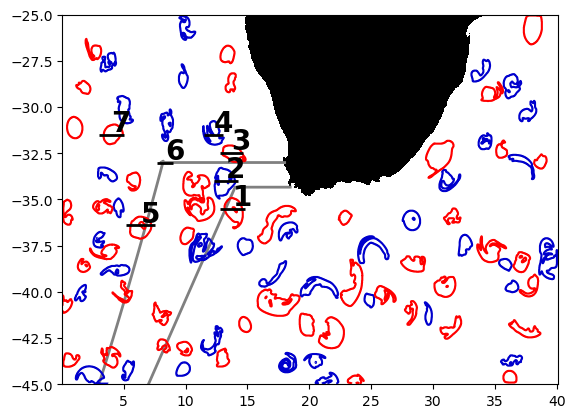

In [11]:
plt.plot(combined_lon, combined_lat, color='gray',linewidth=2)#,linestyle=':')
plt.plot(Ansorge_lon, Ansorge_lat, color='gray',linewidth=2)#,linestyle=':')
plt.contourf(mesh_mask.nav_lon, mesh_mask.nav_lat,
                    mesh_mask.isel(z=0, t=0).tmask.where(mesh_mask.isel(z=0, t=0).tmask == 0), colors="black")
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, ds.isel(time_counter=0, z=0).type, levels=[0.9], colors='mediumblue')
plt.contour(mesh_mask.nav_lon, mesh_mask.nav_lat, -ds.isel(time_counter=0, z=0).type, levels=[0.9], colors='red')
plt.ylim([-45,-25])
for line in lines_data:
    plt.hlines(line['y'], line['x1'], line['x2'], color='black', linewidth=2)
    plt.text((line['x1']+line['x2'])/2, line['y']+.2, line['label'], fontsize=20, weight='extra bold')

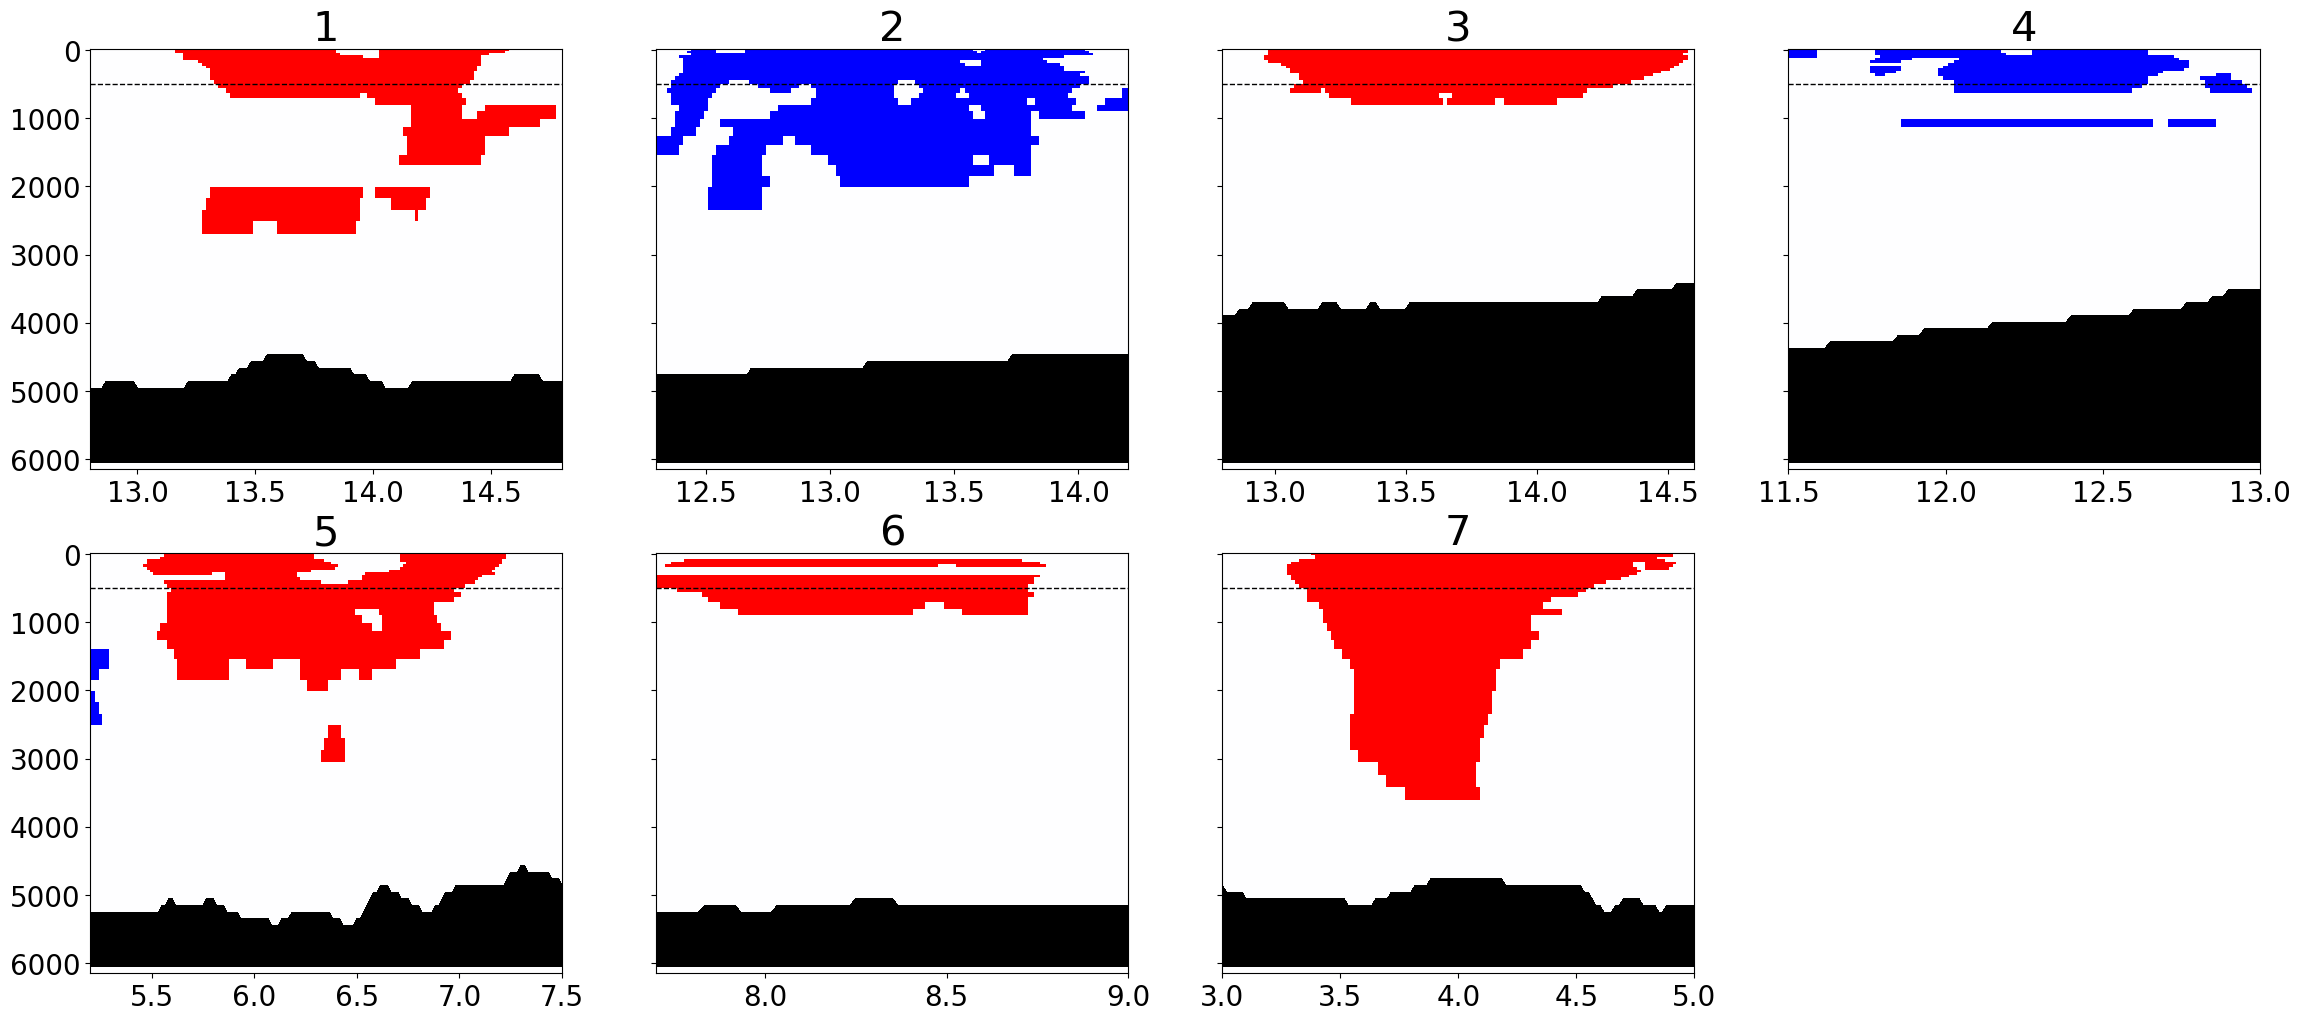

In [12]:
plt.rcParams.update({
    "axes.titlesize": 30, 
    "xtick.labelsize": 20,  
    "ytick.labelsize": 20   
})
n_lines = len(lines_data)
ncols = math.ceil(n_lines / 2) 

fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(7 * ncols, 12), sharey=True)
axes = axes.flatten()
for ax, line in zip(axes, lines_data):
    pcm = ax.pcolormesh(
        mesh_mask.isel(y=line['y_index']).nav_lon, 
        levels, 
        ds.isel(time_counter=0, y=line['y_index']).type, 
        cmap='bwr_r',
    )
    ax.contourf(mesh_mask.nav_lon.isel(y=line['y_index']), mesh_mask.nav_lev,
                    mesh_mask.isel(y=line['y_index'], t=0).tmask.where(mesh_mask.isel(y=line['y_index'], t=0).tmask == 0), colors="black")
    ax.set_xlim([line['x1'], line['x2']])
    ax.invert_yaxis()

    ax.axhline(500, color='black', linestyle='--', linewidth=1)

    #ax.set_yscale('function', functions=(lambda y: np.where(y < 500, y, 500 + (y-500)/3),  
    #                                     lambda y: np.where(y < 500, y, 500 + (y-500)*3)))

    #yticks = np.concatenate((np.arange(0, 600, 100), np.arange(1000, 3100, 500)))
    #ax.set_yticks(yticks)
    #ax.set_yticklabels(yticks)

    ax.set_title(f"{line['label']}")
if n_lines % 2 != 0:
    axes[-1].axis("off")

---

In [13]:
# smoothed
u_ds_smoothed = xr.open_dataset(
    f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
    f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_U.nc',
    chunks={'time_counter': 50}
)
v_ds_smoothed = xr.open_dataset(
    f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
    f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_V.nc',
    chunks={'time_counter': 50}
)
t_ds_smoothed = xr.open_dataset(
    f'/gxfs_work/geomar/smomw523/smoothed_data/{experiment_name}/'
    f'2_{experiment_name}_{data_resolution}_{datestart.replace("-", "")}_{dateend.replace("-", "")}_smoothed_{sigma}_grid_T.nc',
    chunks={'time_counter': 50}
)

In [14]:
# smoothed
T_smoothed = t_ds_smoothed.isel(time_counter = 0).votemper

u_smoothed = u_ds_smoothed.isel(time_counter = 0).vozocrtx
v_smoothed = v_ds_smoothed.isel(time_counter = 0).vomecrty

u_smoothed_depth = u_smoothed.rename({'depthu': 'depth'})
v_smoothed_depth = v_smoothed.rename({'depthv': 'depth'})

vel_INALT_smoothed = xr.combine_by_coords([u_smoothed_depth, v_smoothed_depth], compat='override', combine_attrs='drop_conflicts')
vel_INALT_smoothed["vel"] = np.sqrt(vel_INALT_smoothed.vomecrty**2 + vel_INALT_smoothed.vozocrtx**2)
vel_INALT_smoothed = vel_INALT_smoothed.compute()

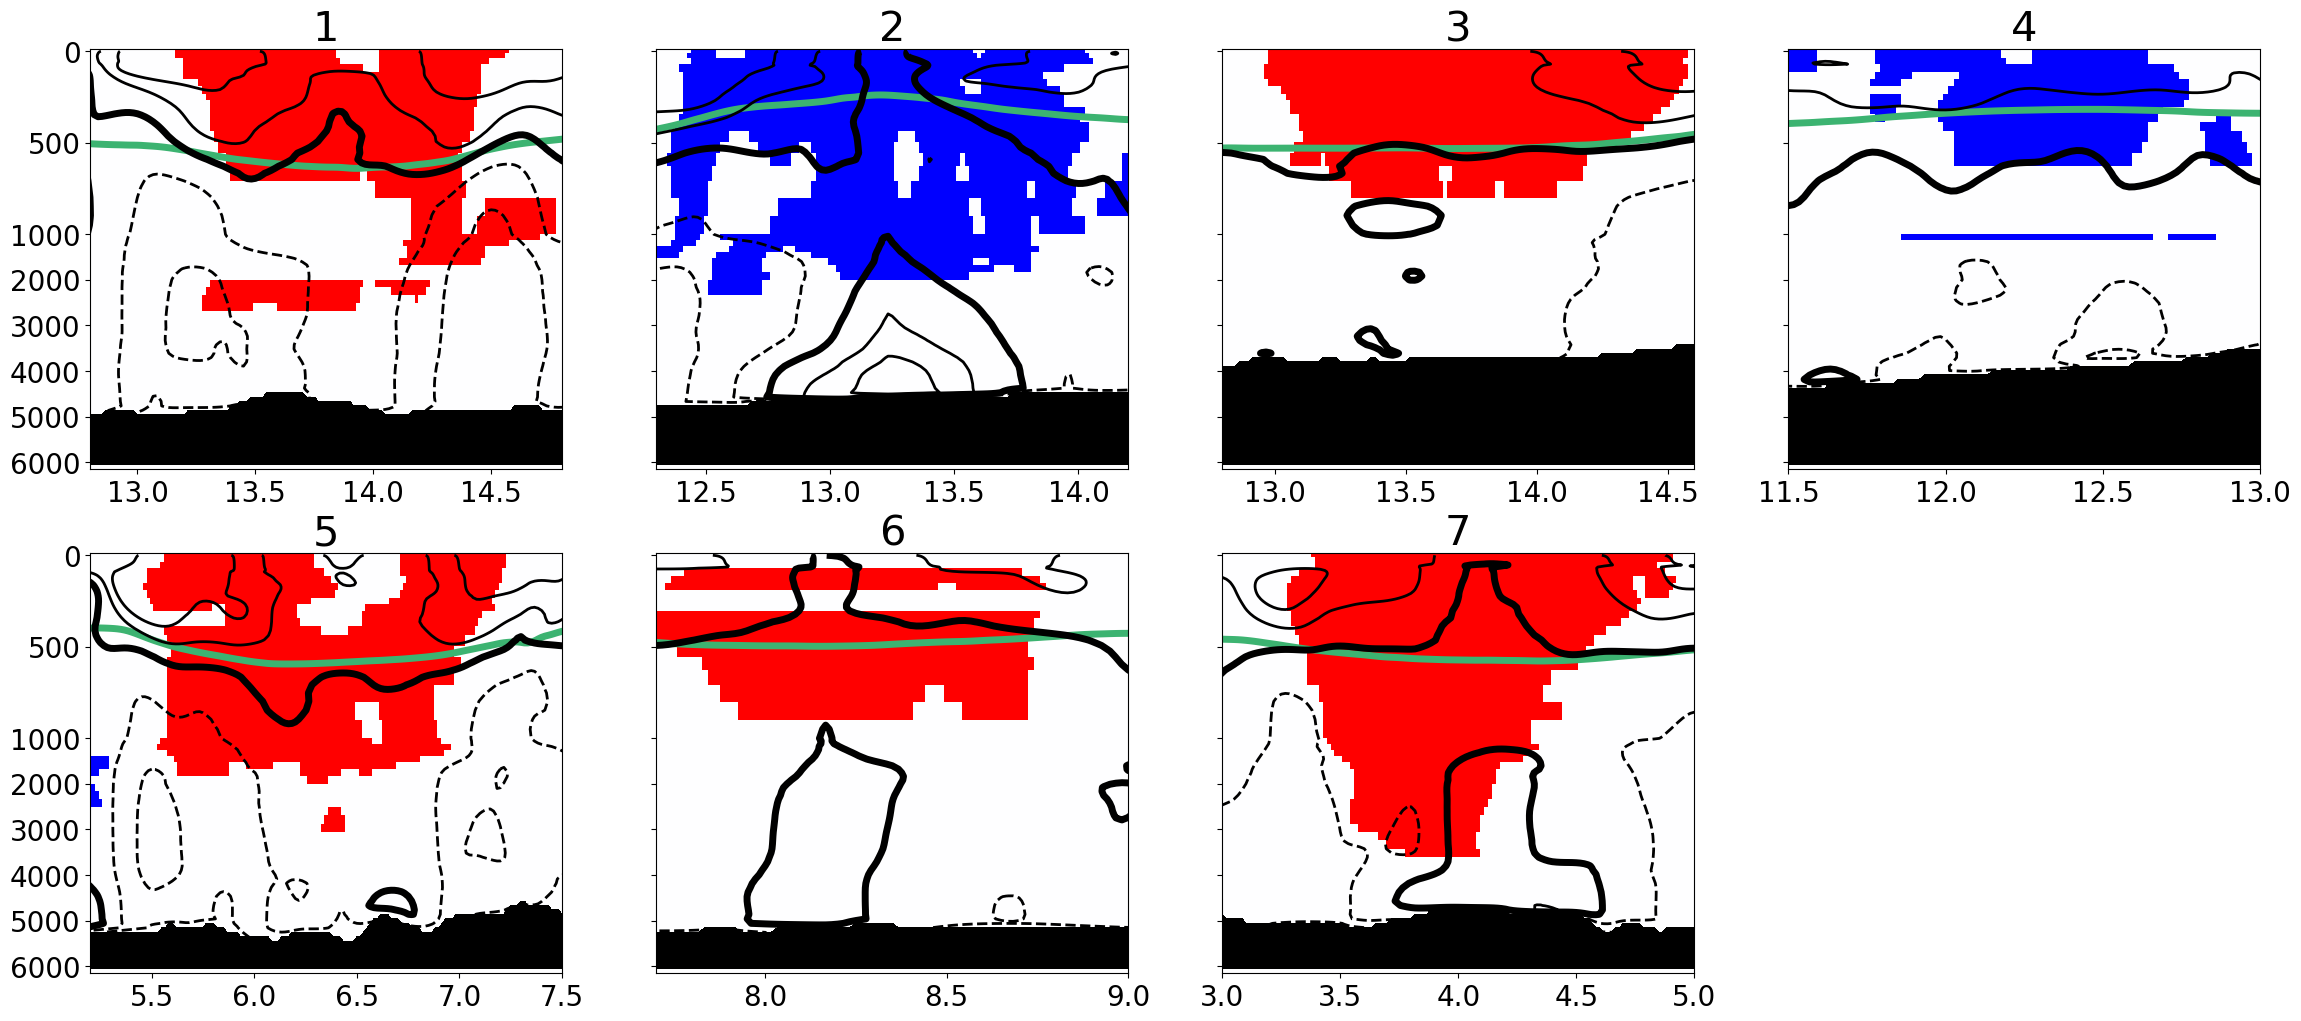

In [15]:
plt.rcParams.update({
    "axes.titlesize": 30, 
    "xtick.labelsize": 20,  
    "ytick.labelsize": 20   
})
n_lines = len(lines_data)
ncols = math.ceil(n_lines / 2) 

fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(7 * ncols, 12), sharey=True)
axes = axes.flatten()
for ax, line in zip(axes, lines_data):
    pcm = ax.pcolormesh(
        mesh_mask.isel(y=line['y_index']).nav_lon, 
        levels, 
        ds.isel(time_counter=0, y=line['y_index']).type, 
        cmap='bwr_r',
    )
    ax.contour(mesh_mask.isel(y=line['y_index']).nav_lon, 
        mesh_mask.nav_lev,
        T_smoothed.isel(y=line['y_index']),
        levels=[10],
        linewidths=5,
        colors='mediumseagreen',
    )
    ax.contour(mesh_mask.isel(y=line['y_index']).nav_lon, 
        mesh_mask.nav_lev,
        vel_INALT_smoothed.isel(y=line['y_index']).vel-vel_INALT_smoothed.isel(y=line['y_index']).vel.mean(dim='depth'),
        levels=[-.2,-.1,.1,.2],
        linewidths=2,
        colors='black',
    )
    ax.contour(mesh_mask.isel(y=line['y_index']).nav_lon, 
        mesh_mask.nav_lev,
        vel_INALT_smoothed.isel(y=line['y_index']).vel-vel_INALT_smoothed.isel(y=line['y_index']).vel.mean(dim='depth'),
        levels=[0],
        linewidths=5,
        colors='black',
    )
    ax.contourf(mesh_mask.nav_lon.isel(y=line['y_index']), mesh_mask.nav_lev,
                    mesh_mask.isel(y=line['y_index'], t=0).tmask.where(mesh_mask.isel(y=line['y_index'], t=0).tmask == 0), colors="black")
    
    ax.set_xlim([line['x1'], line['x2']])
    ax.invert_yaxis()

    ax.set_yscale('function', functions=(lambda y: np.where(y < 1000, y, 1000 + (y-1000)/4),  
                                         lambda y: np.where(y < 1000, y, 1000 + (y-1000)*4)))

    yticks = np.concatenate((np.arange(0, 1000, 500), np.arange(1000, 6100, 1000)))
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticks)

    ax.set_title(f"{line['label']}")
if n_lines % 2 != 0:
    axes[-1].axis("off")

In [16]:
vel_INALT_smoothed.isel(y=line['y_index']).vel.mean(dim='depth')

<xarray.DataArray 'vel' (x: 2404)>
array([0.12670858, 0.13171211, 0.14029843, ..., 0.10100634, 0.09067364,
       0.08465613], dtype=float32)
Coordinates:
    nav_lat        (x) float32 -31.49 -31.49 -31.49 ... -31.49 -31.49 -31.49
    nav_lon        (x) float32 0.05 0.06667 0.08333 0.1 ... 40.07 40.08 40.1
    time_centered  datetime64[ns] 2012-04-10T12:00:00
    time_counter   datetime64[ns] 2012-04-10T12:00:00
Dimensions without coordinates: x